## Mahindra First Choice Data Analysis

### Problem Statements
    1. Geolocation Based Customer Analysis
        * Explore how various factors like make, model, time & type of service, etc vary with location.
            * Identifying the ownership pattern of cars throughout the country.
            * This also captures the problem wherein information regarding the spending patterns can be identified.
        * Identify the type of order each state receives and present it as an interactive visualization.
    2. Market Segmentation
        * Divide market of potential customers into internally homogeneous and mutually heterogeneous groups or segments.
            * To be based on different characteristics captured in the data.
     3. Customer Lifetime value prediction

#### Further Problem Statements
    1. Inventory Management and Recommendation
    2. Marketing Recommendation
    3. Customer Prediction

### The Data

* Dataset contains the following:
    1. Customer Data
    2. Invoice Data
    3. Joint Technical Data
    4. Plant Master

### Data Cleaning and Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import sys
import time
import warnings

from matplotlib import pyplot as plt
from scipy import stats
from my_utils import *

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

In [2]:
customer_data = pd.read_excel("redacted/data/Customer_Data.xlsx", sheet_name='Sheet1')

In [3]:
invoice = pd.read_csv("redacted/data/Final_invoice.csv")

In [4]:
jtd = pd.read_csv("redacted/data/JTD.csv")

In [5]:
plant_master = pd.read_excel("redacted/data/Plant Master.xlsx", sheet_name='Sheet1')

### Customer Data

In [8]:
customer_data_backup = customer_data.copy()

In [10]:
check_null(customer_data)

Total: 555338


,Number_Missing,% Missing,Missing?
Death date,554675,99.880613,True
Date of Birth,541894,97.579132,True
Occupation,540780,97.378533,True
Marital Status,539301,97.112209,True
Title,46307,8.338525,True
Data Origin,136,0.024490,True
Partner Type,78,0.014046,True
Business Partner,0,0.000000,False
Customer No.,0,0.000000,False


* <code>['Death date', 'Date of Birth', 'Occupation', 'Marital Status']</code> have a high number of missing values which would not be possible to impute. Hence dropping these columns.
* <code>['Partner Type', 'Data Origin']</code> have too few a number of missing values which may not justify the time and effort to be put in for diminished gains. Hence dropping the entries where these columns have missing values.

In [11]:
if 'Occupation' in customer_data.columns:
    customer_data.drop(columns=['Death date', 'Date of Birth', 'Occupation', 'Marital Status'], axis=1, inplace=True)
if 'Partner Type' in customer_data.columns:
    customer_data.drop(customer_data[customer_data['Partner Type'].isnull() | customer_data['Data Origin'].isnull()].index,
                       axis=0, inplace=True)

In [12]:
def(customer_data)

Total: 555202


,Number_Missing,% Missing,Missing?
Title,46177,8.317153,True
Business Partner,0,0.000000,False
Customer No.,0,0.000000,False
Partner Type,0,0.000000,False
Data Origin,0,0.000000,False


In [13]:
customer_data['Title'].nunique()

2

In [14]:
customer_data['Title'].value_counts()*100/customer_data.notnull().sum()['Title']

2.0    95.070183
1.0     4.929817
Name: Title, dtype: float64

In [15]:
customer_data_backup[ customer_data_backup['Title'].isnull()].isnull().sum()

Business Partner        0
Customer No.            0
Partner Type           76
Data Origin           130
Title               46307
Marital Status      44778
Occupation          45419
Date of Birth       44509
Death date          46278
dtype: int64

* The <code>Title</code> only contains <code>['Mr.', 'Mrs.']</code>. <code>['Company', 'Mr. and Mrs.']</code> weren't found.
* They have an imbalanced distribution.
* There seems to be no features that would aid in predicting the <code>Title</code> before merging.
* Proceeding without imputing values. If features do not allow prediction of <code>Title</code> after merging, may resort to using a naive approach such as randomly imputing values based on present percentage distribution.

In [16]:
customer_data['Business Partner'].nunique()
len(customer_data)

555202

555202

In [17]:
customer_data['Customer No.'].nunique()
len(customer_data)

555202

555202

* <code>['Customer No.', 'Business Partner']</code> seem to be some sort of identifiers for internal and external systems.
* Both contain all unique values with no repetition.
* They will not affect the overall prediction power, hence they may be dropped once data is merged and ready for training.

In [18]:
customer_data['Partner Type'].nunique()

7

In [19]:
customer_data['Data Origin'].nunique()

22

In [20]:
check_null(customer_data)

Total: 555202


,Number_Missing,% Missing,Missing?
Title,46177,8.317153,True
Business Partner,0,0.000000,False
Customer No.,0,0.000000,False
Partner Type,0,0.000000,False
Data Origin,0,0.000000,False


In [21]:
customer_data['Title'].value_counts()
customer_data['Title'].value_counts()/customer_data['Title'].value_counts().sum()

2.0    483931
1.0     25094
Name: Title, dtype: int64

2.0    0.950702
1.0    0.049298
Name: Title, dtype: float64

In [22]:
len(customer_data[ (customer_data['Title']==2.0) & (customer_data['Partner Type']!=1.0) ])

111

In [23]:
(customer_data[ customer_data['Title']==2.0 ]['Partner Type'].value_counts()/len(customer_data[ customer_data['Title']==2.0 ])).sort_index()

1.0       0.999771
2.0       0.000010
3.0       0.000048
4.0       0.000048
9001.0    0.000064
9002.0    0.000002
9003.0    0.000058
Name: Partner Type, dtype: float64

In [24]:
len(customer_data[ (customer_data['Title']==1.0) & (customer_data['Partner Type']!=1.0) ])

22

In [25]:
(customer_data[ customer_data['Title']==1.0 ]['Partner Type'].value_counts()/len(customer_data[ customer_data['Title']==1.0 ])).sort_index()

1.0       0.999123
2.0       0.000159
3.0       0.000120
4.0       0.000159
9001.0    0.000319
9003.0    0.000120
Name: Partner Type, dtype: float64

Since the values are incredibly imbalanced, it would make sense to impute the most common value.

In [26]:
0.950702*len(customer_data[ customer_data['Title'].isnull() ])
0.049298*len(customer_data[ customer_data['Title'].isnull() ])

43900.566254000005

2276.433746

In [27]:
customer_data = customer_data.reset_index()
random_positions = random.sample( list( customer_data[ customer_data['Title'].isnull() ].index ),
                                 k=2277)

mask_array = np.array([False]*len(customer_data))

for position in random_positions:
    mask_array[position] = True

In [28]:
customer_data['Title'] = np.where(mask_array, 2.0, customer_data['Title'])
customer_data['Title'] = customer_data['Title'].fillna(1.0)
customer_data.set_index(keys=['index'], inplace=True)

In [83]:
customer_data.to_csv('customer_data_cleaned.csv')

In [5]:
customer_data = pd.read_csv('customer_data_cleaned.csv', index_col='index')

In [7]:
customer_data.head()

,Business Partner,Customer No.,Partner Type,Data Origin,Title
index,,,,,
0,31,1,1.0,Z001,1.0
1,32,2,1.0,Z005,1.0
2,34,4,1.0,Z005,1.0
3,35,5,1.0,Z005,1.0
4,42,7,1.0,Z008,1.0


### Invoice

In [29]:
invoice_backup = invoice.copy()

In [402]:
missing_df = check_null(invoice)
missing_df

Total: 492314


,Number_Missing,% Missing,Missing?
Service Advisor Name,492314,100.000000,True
Claim No.,487510,99.024200,True
Policy no.,475432,96.570888,True
Expiry Date,470083,95.484386,True
Insurance Company,468723,95.208140,True
Cash /Cashless Type,464894,94.430384,True
Gate Pass Date,451399,91.689247,True
Technician Name,236834,48.106290,True
SGST/UGST(2.5%),197286,40.073205,True
Amt Rcvd From Custom,197286,40.073205,True


In [403]:
recurring_df = check_recurring(invoice)
recurring_df

,Column,Unique Values,Not Null Values,Ratio to Total Number,Has Null
1,Amt Rcvd From Custom,1,295028,0.000003,True
2,Amt Rcvd From Ins Co,1,295028,0.000003,True
4,CGST(14%),1,295028,0.000003,True
5,CGST(2.5%),1,295028,0.000003,True
6,CGST(6%),1,295028,0.000003,True
7,CGST(9%),1,295028,0.000003,True
17,IGST(12%),1,295028,0.000003,True
18,IGST(18%),1,295028,0.000003,True
19,IGST(28%),1,295028,0.000003,True
20,IGST(5%),1,295028,0.000003,True


In [404]:
columns_to_drop = set()

# more than 90% missing values
for i in list(missing_df[missing_df['% Missing']>90].index):
    columns_to_drop.add(i)

# columns that have just a single value
for i in list(recurring_df[ recurring_df['Unique Values']==1]['Column']):
    columns_to_drop.add(i)

# dropping the columns
invoice.drop(columns=list(columns_to_drop), axis=1, inplace=True)

In [25]:
check_null(invoice[[i for i in invoice.columns if i not in columns_to_drop]])
check_recurring(invoice[[i for i in invoice.columns if i not in columns_to_drop]])

Total: 492314


,Number_Missing,% Missing,Missing?
Technician Name,236834,48.106290,True
Total Value,197286,40.073205,True
ODN No.,197286,40.073205,True
Area / Locality,23890,4.852594,True
Model,1525,0.309762,True
Regn No,16,0.003250,True
CITY,1,0.000203,True
Pin code,0,0.000000,False
OSL Total,0,0.000000,False
Order Type,0,0.000000,False


,Column,Unique Values,Not Null Values,Ratio to Total Number,Has Null
17,Model,245,490789,0.000499,True
2,CITY,19580,492313,0.039771,True
28,Technician Name,15044,255480,0.058885,True
1,Area / Locality,65509,468424,0.139850,True
27,Regn No,260324,492298,0.528794,True
30,Total Value,168861,295028,0.572356,True
18,ODN No.,295028,295028,1.000000,True
25,Print Status,2,492314,0.000004,False
3,Cust Type,7,492314,0.000014,False
20,Order Type,9,492314,0.000018,False


In [26]:
(invoice['Total Value'] / invoice['Total Amt Wtd Tax.'] ).value_counts()

1.0    261568
dtype: int64

* Now the remaining fields <code>['Technician Name', 'Total Value', 'ODN No.']</code> remain with significant missing values.
* <code>Technician Name</code> may later prove useful for Customer Prediction.
* <code>ODN No.</code> contains unique values apart from those missing. It doesn't give much else information and doesn't seem to be of use for any other tasks. Will drop it.
* <code>Total Value</code> contains the values same as <code>Total Amt Wtd Tax.</code>, hence will be dropping it as well.

In [405]:
invoice.drop(columns=['Total Value', 'ODN No.'], axis=1, inplace=True)

In [28]:
check_null(invoice)

Total: 492314


,Number_Missing,% Missing,Missing?
Technician Name,236834,48.106290,True
Area / Locality,23890,4.852594,True
Model,1525,0.309762,True
Regn No,16,0.003250,True
CITY,1,0.000203,True
Unnamed: 0,0,0.000000,False
Misc Total,0,0.000000,False
Total Amt Wtd Tax.,0,0.000000,False
Recovrbl Exp,0,0.000000,False
Print Status,0,0.000000,False


* Since the customer segmentation needs to be carried out on their geological location, the 4.8% missing values in <code>['Area / Locality', 'CITY']</code> may need to be imputed.
* This will be done using the <code>District</code> column and <code>Plant Master</code> data.

In [447]:
def clean_and_add_values(plant_property):
    property_index = []
    property_value_counts = plant_property.value_counts()
    if type(property_value_counts.index[0]) == str:
        property_index = [ x.lower() for x in list(property_value_counts.index)] 
    else:
        property_index = list(property_value_counts.index)
        
    property_values = list(property_value_counts.values)
    
    property_index_set = set(property_index)
    
    # if there's more than one value
    if len(property_index_set) > 1:
        # find the occurences of all the different values' case occurrences
        for i in property_index_set:
            property_index_occurences = [k for k, x in enumerate(property_index) if x == i]
            if len(property_index_occurences) > 1:
                # add multiple occurences of different case values
                for j in range(1, len(property_index_occurences)):
                    property_values[property_index_occurences[0]] += property_values[j]
                    property_values[j] = 0
                    
    property_cleaned_and_added = pd.Series(data=property_values, index=property_value_counts.index)
    property_cleaned_and_added = property_cleaned_and_added.sort_values(ascending=False)
    
    property_decided_value = \
        property_cleaned_and_added[property_cleaned_and_added == property_cleaned_and_added.iloc[0]].index[0]
    
    chosen_index = 1
    if type(property_decided_value) == str:
        if len(property_decided_value.strip()) < 2:
            while( property_decided_value in [',', '.', '..', '...']):
                property_decided_value = \
                    property_cleaned_and_added[property_cleaned_and_added == property_cleaned_and_added.iloc[chosen_index]].index[0]
                chosen_index += 1
    return property_decided_value

In [407]:
plants = list( set(invoice['Plant']))
plants.sort()

In [450]:
final_invoice = invoice.copy()

for i in range(0, len(plants)):
    
    j = plants[i]
    properties_to_clean = ['CITY', 'Area / Locality', 'District', 'Pin code', 'Plant Name1']
    
    for property_ in properties_to_clean:
        cleaned_property = clean_and_add_values(final_invoice[ final_invoice['Plant'] == j ][property_])
        final_invoice[property_] = np.where(final_invoice['Plant'] == j, cleaned_property, final_invoice[property_])
        
    print(' '*40, end="")
    print("\r{0}% completed".format(np.around( i/len(plants)*100, decimals=2)), end="")
    print("                                            \r", end="")
print("\r                                            ", end="")
print("\r100% Complete")

In [449]:
invoice = final_invoice.copy()

In [33]:
check_null(invoice)

Total: 492314


,Number_Missing,% Missing,Missing?
Technician Name,236834,48.106290,True
Model,1525,0.309762,True
Regn No,16,0.003250,True
Unnamed: 0,0,0.000000,False
Area / Locality,0,0.000000,False
Total Amt Wtd Tax.,0,0.000000,False
Recovrbl Exp,0,0.000000,False
Print Status,0,0.000000,False
Plant Name1,0,0.000000,False
Plant,0,0.000000,False


In [34]:
check_recurring(invoice)

,Column,Unique Values,Not Null Values,Ratio to Total Number,Has Null
17,Model,245,490789,0.000499,True
27,Technician Name,15044,255480,0.058885,True
26,Regn No,260324,492298,0.528794,True
24,Print Status,2,492314,0.000004,False
3,Cust Type,7,492314,0.000014,False
19,Order Type,9,492314,0.000018,False
5,District,22,492314,0.000045,False
15,Make,28,492314,0.000057,False
25,Recovrbl Exp,192,492314,0.000390,False
2,CITY,200,492314,0.000406,False


* Across the invoice data, the same <code>Regn No</code> comes up more than once, indicating that some frequent customers exist.
* Segmentation may also be carried out on the number of times a car has visited the shop.
* Some <code>Regn No.</code> were found to be missing. Maybe the <code>Customer No.</code> will overlap with the overlap in <code>Regn No.</code>

In [451]:
for customer_no in list(invoice[invoice['Regn No'].isnull()]['Customer No.']):
    invoice[invoice['Customer No.'] == customer_no][['Customer No.', 'CITY', 'Make', 'Regn No']].sort_values(by="Regn No", ascending=False)

,Customer No.,CITY,Make,Regn No
44520,89879,THANJAVUR,TATA MOTORS,TN49AF4561
85081,89879,THANJAVUR,TATA MOTORS,TN49AF4561
15960,89879,THANJAVUR,TATA MOTORS,NaN


,Customer No.,CITY,Make,Regn No
86231,110197,SHIMOGA,FORD,KA03MF2245
96900,110197,SHIMOGA,FORD,KA03MF2245
362678,110197,SHIMOGA,FORD,KA03MF2245
55362,110197,SHIMOGA,FORD,NaN


,Customer No.,CITY,Make,Regn No
229899,4205,CHENNAI,SKODA,TN10T7090
88881,4205,chengalpet,SKODA,NaN
88947,4205,chengalpet,SKODA,NaN
314367,4205,chengalpet,SKODA,NaN


,Customer No.,CITY,Make,Regn No
229899,4205,CHENNAI,SKODA,TN10T7090
88881,4205,chengalpet,SKODA,NaN
88947,4205,chengalpet,SKODA,NaN
314367,4205,chengalpet,SKODA,NaN


,Customer No.,CITY,Make,Regn No
155881,56325,PUNE,GENERAL MOTORS,NaN


,Customer No.,CITY,Make,Regn No
221864,723,MUMBAI,HYUNDAI,NaN


,Customer No.,CITY,Make,Regn No
223647,1538,Hyderabad,MAHINDRA & MAHINDRA,AP28BQ2499
224134,1538,Hyderabad,MAHINDRA & MAHINDRA,NaN
229144,1538,Hyderabad,MAHINDRA & MAHINDRA,NaN


,Customer No.,CITY,Make,Regn No
223647,1538,Hyderabad,MAHINDRA & MAHINDRA,AP28BQ2499
224134,1538,Hyderabad,MAHINDRA & MAHINDRA,NaN
229144,1538,Hyderabad,MAHINDRA & MAHINDRA,NaN


,Customer No.,CITY,Make,Regn No
242052,9856,MUMBAI,GENERAL MOTORS,NaN


,Customer No.,CITY,Make,Regn No
223308,1397,MUMBAI,MARUTI SUZUKI,MH04DY4044
233667,1397,MUMBAI,MARUTI SUZUKI,MH04DY4044
243726,1397,MUMBAI,MARUTI SUZUKI,MH04DY4044
244449,1397,MUMBAI,HONDA,NaN


,Customer No.,CITY,Make,Regn No
271857,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A8088
271438,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A8087
201210,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6340
249482,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6340
260394,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6340
270566,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6340
205073,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6338
249481,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6338
259237,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6338
260357,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6338


,Customer No.,CITY,Make,Regn No
271857,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A8088
271438,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A8087
201210,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6340
249482,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6340
260394,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6340
270566,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6340
205073,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6338
249481,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6338
259237,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6338
260357,11063,BENGALURU,MAHINDRA & MAHINDRA,KA41A6338


,Customer No.,CITY,Make,Regn No
243916,10435,BENGALURU,FORD,MH01VA1371
248784,10435,BENGALURU,FORD,MH01VA1371
257175,10435,BENGALURU,FORD,MH01VA1371
261639,10435,BENGALURU,FORD,MH01VA1371
270910,10435,BENGALURU,FORD,MH01VA1371
278674,10435,BENGALURU,FORD,MH01VA1371
292115,10435,BENGALURU,FORD,MH01VA1371
245810,10435,BENGALURU,FORD,NaN


,Customer No.,CITY,Make,Regn No
229899,4205,CHENNAI,SKODA,TN10T7090
88881,4205,chengalpet,SKODA,NaN
88947,4205,chengalpet,SKODA,NaN
314367,4205,chengalpet,SKODA,NaN


,Customer No.,CITY,Make,Regn No
406884,222086,chengalpet,SKODA,NaN


,Customer No.,CITY,Make,Regn No
323002,158249,DEWAS,VOLKSWAGEN,MP09TA6863
323007,158249,DEWAS,VOLKSWAGEN,MP09TA6863
407195,158249,DEWAS,VOLKSWAGEN,MP09TA6863
420452,158249,DEWAS,MARUTI SUZUKI,MP09CL8407
407189,158249,DEWAS,MARUTI SUZUKI,NaN


In [452]:
# imputing the values using available data
# could  have done it with code but that would take too much time for 12 entries
invoice['Regn No'] = np.where(invoice.index == 55362, 'KA03MF2245', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 15960, 'TN49AF4561', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 224134, 'AP28BQ2499', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 229144, 'AP28BQ2499', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 244468, 'KA41A6340', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 244470, 'KA41A6340', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 245810, 'MH01VA1371', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 88881, 'TN10T7090', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 88947, 'TN10T7090', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 314367, 'TN10T7090', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 407189, 'MP09CL8407', invoice['Regn No'])

# Synthetic number plates
invoice['Regn No'] = np.where(invoice.index == 155881, 'MH66WW6666', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 221864, 'MH77XX7777', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 242052, 'MH88YY8888', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 244449, 'MH99ZZ9999', invoice['Regn No'])
invoice['Regn No'] = np.where(invoice.index == 406884, 'TN99ZZ9999', invoice['Regn No'])

In [75]:
check_null(invoice)

Total: 492314


,Number_Missing,% Missing,Missing?
Technician Name,236834,48.106290,True
Model,1525,0.309762,True
Unnamed: 0,0,0.000000,False
Area / Locality,0,0.000000,False
Total Amt Wtd Tax.,0,0.000000,False
Regn No,0,0.000000,False
Recovrbl Exp,0,0.000000,False
Print Status,0,0.000000,False
Plant Name1,0,0.000000,False
Plant,0,0.000000,False


In [453]:
for number_plate in list(invoice[ invoice['Model'].isnull() ]['Regn No']):
    car_records = invoice[ invoice['Regn No'] == number_plate][['Customer No.', 'Make', 'Model']]
    
    if len(car_records[ car_records['Model'].notnull() ]) >= 1:
        car_model_value_counts = car_records['Model'].value_counts().sort_values(ascending=False)
#         car_model_value_counts.index[0]
        invoice['Model'] = np.where(invoice['Regn No'] == number_plate,
                                      car_model_value_counts.index[0], 
                                      invoice['Model'])

In [79]:
check_null(invoice)

Total: 492314


,Number_Missing,% Missing,Missing?
Technician Name,236834,48.106290,True
Model,1408,0.285996,True
Unnamed: 0,0,0.000000,False
Area / Locality,0,0.000000,False
Total Amt Wtd Tax.,0,0.000000,False
Regn No,0,0.000000,False
Recovrbl Exp,0,0.000000,False
Print Status,0,0.000000,False
Plant Name1,0,0.000000,False
Plant,0,0.000000,False


* Further imputation would require manual input. Dropping the remaining values.

In [454]:
invoice.drop(invoice[ invoice['Model'].isnull() ].index, axis=0, inplace=True)

In [43]:
invoice = attach_frequency(invoice, 'Regn No')
invoice = attach_frequency(invoice, 'Customer No.')

In [101]:
invoice.head()

,Unnamed: 0,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency
0,0,THANE,THANE,Retail,67849,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,...,BC01,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,5,5
1,1,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,...,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,6,6
2,2,THANE,THANE,Retail,81055,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,...,BC01,THANE,NO,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,3,3
3,3,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,...,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,6,6
4,4,THANE,THANE,Retail,18980,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,...,BC01,THANE,NO,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,8,8


In [102]:
invoice[ invoice['Regn No_frequency'] != invoice['Customer No._frequency']]

,Unnamed: 0,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency
5,5,THANE,THANE,Retail,84457,Maharashtra,00:00:00,2015-01-03,7005200007,12:10:08,...,BC01,THANE,NO,0.0,MH04GM2960,DAYANAND,865.92,BC01SA2,2,3
9,9,THANE,THANE,Retail,84457,Maharashtra,00:00:00,2015-01-03,7005200011,15:54:21,...,BC01,THANE,NO,0.0,GA07E3439,DAYANAND,3912.61,BC01SA1,1,3
16,16,THANE,THANE,Retail,84371,Maharashtra,00:00:00,2015-01-03,7005200018,18:31:39,...,BC01,THANE,NO,0.0,MH04EF5050,RUPESH,4549.94,BC01SA2,5,7
40,40,THANE,THANE,Retail,63460,Maharashtra,00:00:00,2015-01-07,7005200042,19:49:26,...,BC01,THANE,NO,0.0,MP09CH0868,HARSHAD,1286.92,BC01SA1,2,3
54,54,THANE,THANE,Retail,E3930,Maharashtra,00:00:00,2015-01-10,7005200056,11:00:28,...,BC01,THANE,NO,0.0,MH02JP8453,HARSHAD,8000.20,BC01SA1,27,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490782,984617,MEHSANA,MEHSANA,Retail,186231,Gujarat,00:00:00,2016-06-29,7215600181,17:59:16,...,X328,X328 - PRAMUKH AUTO,NO,0.0,GJ5CK8760,NaN,2930.48,X328SA1,1,3
490800,984635,RAMANATHAPURAM,CBE,Retail,166971,Tamil Nadu,00:00:00,2016-06-28,7216200041,18:26:01,...,X331,X331 - NEXSTEP AUTO CARE,NO,0.0,TN38CA5230,NaN,753.88,X331SA1,4,3
490878,984713,NIZAMABAD,NIZAMABAD,Retail,204228,Telangana,00:00:00,2016-06-30,7227200072,17:41:08,...,X386,X386 - VINAYAKA MOTORS,NO,0.0,AP09BC9492,NaN,2597.84,X386SA1,1,2
490896,984731,.,CHENNAI,Retail,255,Tamil Nadu,00:00:00,2016-06-30,7231000012,13:35:52,...,X405,X405 - NANGAN MOTORS PVT. LTD.,NO,0.0,TN07AS2359,NaN,434.80,X405SA1,13,14


In [126]:
grouped_obj = invoice.groupby('Regn No')

In [133]:
owners_dict = {}

for regn_no in grouped_obj.groups.keys():
    occurrences = grouped_obj.groups[regn_no]

    owners = set()
    
    for index_location in occurrences:
        owners.add(invoice.loc[index_location, 'Customer No.'])

    owners_dict[regn_no] = list(owners)

In [143]:
invoice['Owned By (customers)'] = -1
invoice['Owned By (total number)'] = -1

registration_numbers = list(set(invoice['Regn No']))
total = len(registration_numbers)

for sno, reg_no in enumerate(registration_numbers):
    invoice['Owned By (customers)'] = np.where(invoice['Regn No'] == reg_no, str(owners_dict[reg_no]),
                                               invoice['Owned By (customers)'])
    invoice['Owned By (total number)'] = np.where(invoice['Regn No'] == reg_no, len(owners_dict[reg_no]),
                                                 invoice['Owned By (total number)'])
    print('\r{0}\r'.format(sno*100/total), end='')

In [144]:
invoice.to_csv('invoice_processed.csv')

In [44]:
invoice = pd.read_csv('invoice_processed.csv')
invoice.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Owned By'], axis=0, inplace=True)

In [79]:
invoice.to_csv('invoice_cleaned.csv')

In [12]:
invoice = pd.read_csv('invoice_cleaned.csv', index_col=0)

In [13]:
invoice.head()

,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,Job Card No,...,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency,Owned By (customers),Owned By (total number)
0,THANE,THANE,Retail,67849,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,168303,...,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,5,5,['67849'],1
1,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,173997,...,NO,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,6,6,['84419'],1
2,THANE,THANE,Retail,81055,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,173889,...,NO,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,3,3,['81055'],1
3,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,174158,...,NO,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,6,6,['84419'],1
4,THANE,THANE,Retail,18980,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,173860,...,NO,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,8,8,['18980'],1


#### Looking for usable features (different costs and ratios)

In [58]:
invoice[['Customer No.', 'Gate Pass Time', 'Invoice Date', 'Invoice Time', 'JobCard Date', 'JobCard Time', 'KMs Reading', 'OSL Total', 'Parts Total', 'Labour Total', 'Misc Total', 'Total Amt Wtd Tax.']]

,Customer No.,Gate Pass Time,Invoice Date,Invoice Time,JobCard Date,JobCard Time,KMs Reading,OSL Total,Parts Total,Labour Total,Misc Total,Total Amt Wtd Tax.
0,67849,00:00:00,2015-01-02,11:30:36,2014-12-13,14:29:43,49317,500.06,2348.75,1203.14,0.00,4051.95
1,84419,00:00:00,2015-01-03,10:07:32,2015-01-02,14:12:18,78584,0.00,0.00,804.26,197.03,1001.29
2,81055,00:00:00,2015-01-03,11:12:57,2015-01-02,11:40:44,33985,0.00,52.95,180.19,0.00,233.14
3,84419,00:00:00,2015-01-03,11:40:44,2015-01-03,10:12:32,78584,0.00,0.00,0.00,0.00,0.00
4,18980,00:00:00,2015-01-03,12:07:17,2015-01-02,10:45:42,50057,499.99,944.16,1202.97,100.00,2747.12
...,...,...,...,...,...,...,...,...,...,...,...,...
490901,203820,00:00:00,2016-06-30,14:56:58,2016-06-30,09:15:12,72546,0.00,1587.28,2495.90,374.97,4458.15
490902,170411,00:00:00,2016-06-30,15:06:52,2016-06-30,08:42:15,18968,0.00,4388.61,2443.47,0.00,6832.08
490903,48811,00:00:00,2016-06-30,15:43:56,2016-06-30,08:27:51,177433,0.00,6588.79,2598.92,0.00,9187.71
490904,204067,00:00:00,2016-06-30,15:58:59,2016-06-30,12:53:48,22932,0.00,0.00,11000.00,100.00,11100.00


In [60]:
verify_total = invoice['OSL Total'] + invoice['Parts Total'] + invoice['Labour Total'] + invoice['Misc Total']

In [68]:
difference =  invoice['Total Amt Wtd Tax.'] - verify_total

In [77]:
min(difference), max(difference)

(-1.1641532182693481e-10, 5.820766091346741e-11)

* The sum of values is correct.

In [55]:
temp____ = [i for i in invoice.columns]
temp____.sort()
temp____

['Area / Locality',
 'CITY',
 'Cust Type',
 'Customer No.',
 'Customer No._frequency',
 'District',
 'Gate Pass Time',
 'Invoice Date',
 'Invoice No',
 'Invoice Time',
 'Job Card No',
 'JobCard Date',
 'JobCard Time',
 'KMs Reading',
 'Labour Total',
 'Make',
 'Misc Total',
 'Model',
 'OSL Total',
 'Order Type',
 'Owned By (customers)',
 'Owned By (total number)',
 'Parts Total',
 'Pin code',
 'Plant',
 'Plant Name1',
 'Print Status',
 'Recovrbl Exp',
 'Regn No',
 'Regn No_frequency',
 'Technician Name',
 'Total Amt Wtd Tax.',
 'User ID']

#### Cleaning ['JobCard Date', 'JobCard Time', 'Invoice Date', 'Invoice Time', 'Gate Pass Time']

In [97]:
from datetime import datetime
from datetime import timedelta

In [85]:
def convert_to_datetime(item):
    try:
        return datetime.strptime(item, "%Y-%m-%d %H:%M:%S")
    except:
        print("Couldn't parse: {0}".format(item))
        assert False

In [62]:
for column in ['JobCard Date', 'JobCard Time', 'Invoice Date', 'Invoice Time', 'Gate Pass Time']:
    invoice[column].apply(lambda x: type(x)).value_counts()

<class 'str'>    490906
Name: JobCard Date, dtype: int64

<class 'str'>    490906
Name: JobCard Time, dtype: int64

<class 'str'>    490906
Name: Invoice Date, dtype: int64

<class 'str'>    490906
Name: Invoice Time, dtype: int64

<class 'str'>    490906
Name: Gate Pass Time, dtype: int64

In [65]:
invoice['JobCard DateTime'] = invoice['JobCard Date'] + " " + invoice['JobCard Time']
invoice['JobCard DateTime'] = invoice['JobCard DateTime'].apply(convert_to_datetime)

In [90]:
invoice['Invoice DateTime'] = invoice['Invoice Date'] + " " + invoice['Invoice Time']
invoice['Invoice DateTime'] = invoice['Invoice DateTime'].apply(convert_to_datetime)

In [95]:
invoice['Total Time'] = invoice['Invoice DateTime'] - invoice['JobCard DateTime']
invoice['Total Time'] = invoice['Total Time'].apply(timedelta.total_seconds)

In [103]:
invoice[ invoice['Total Time'] <= 0]

,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,Job Card No,...,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency,Owned By (customers),Owned By (total number),JobCard DateTime,Invoice DateTime,Total Time


In [114]:
invoice.drop(invoice[ invoice['Total Time'] <= 0].index, axis=0, inplace=True)

#### Normalizing time taken

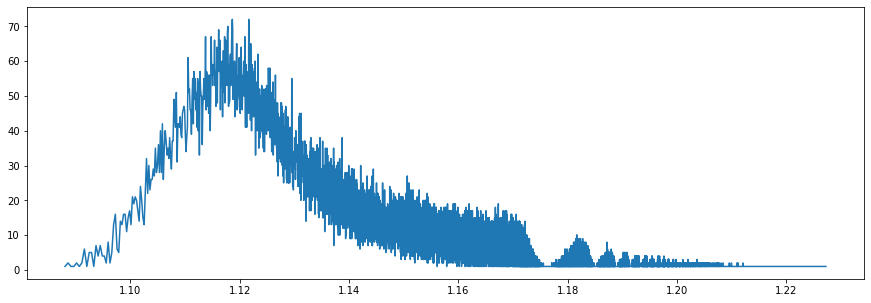

In [276]:
normalized_total_time = pd.Series(stats.boxcox(invoice['Total Time'])[0]).apply(lambda x: x**(1/16))

total_time_vc = (normalized_total_time).value_counts().sort_index()
_ = plt.figure(figsize=(15, 5))
_ = plt.plot(total_time_vc)
plt.show()

In [277]:
invoice['Total Time Unskewed'] = normalized_total_time

In [17]:
invoice[ invoice['Gate Pass Time'] != '00:00:00' ][['JobCard Date', 'JobCard Time', 'Invoice Date', 'Invoice Time', 'Gate Pass Time']].head()

,JobCard Date,JobCard Time,Invoice Date,Invoice Time,Gate Pass Time
5676,2015-01-28,11:07:47,2015-01-28,13:18:59,17:50:23
9558,2015-02-05,18:26:31,2015-02-07,19:44:54,11:14:15
10406,2014-12-13,11:19:00,2015-02-28,17:24:52,11:55:58
13982,2015-02-10,14:46:46,2015-02-10,16:18:52,18:16:21
18674,2015-03-31,20:45:10,2015-03-31,21:50:27,21:03:14


#### Looking for customers who have visited different service centers

In [311]:
_ = invoice.groupby(['Customer No.'])

In [357]:
df = (_['Plant']).value_counts().sort_index().to_frame()
df.columns = ['Visits']
df.reset_index(inplace=True)


df.head()

,Customer No.,Plant,Visits
0,1,BC02,4
1,10,BC01,5
2,100,BC11,2
3,1000,BC02,6
4,10000,BC05,7


In [369]:
vc = df['Customer No.'].value_counts()
multi_plant_customers = list(vc[ vc>1 ].index)

In [456]:
invoice[ invoice['Customer No.'].isin(multi_plant_customers)]

# refer annexure at end

,Unnamed: 0,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID
25,25,THANE,THANE,Retail,80479,Maharashtra,00:00:00,2015-01-04,7005200027,14:21:00,...,882.98,400607,BC01,THANE,NO,0.0,MH03AB0789,RUPESH,1470.94,BC01SA2
26,26,THANE,THANE,Retail,75177,Maharashtra,00:00:00,2015-01-04,7005200028,15:18:55,...,0.00,400607,BC01,THANE,NO,0.0,MH12ET8261,DAYANAND,0.00,BC01SA2
37,37,THANE,THANE,Retail,3457,Maharashtra,00:00:00,2015-01-07,7005200039,10:44:45,...,5567.15,400607,BC01,THANE,NO,0.0,MH02BM8654,PRASHANT,11609.10,BC01SA2
42,42,THANE,THANE,Retail,536,Maharashtra,00:00:00,2015-01-08,7005200044,15:12:40,...,1615.62,400607,BC01,THANE,NO,0.0,MH03AF5463,Ananta,4441.75,BC01SA1
48,48,THANE,THANE,Retail,8120,Maharashtra,00:00:00,2015-01-09,7005200050,16:26:48,...,11006.98,400607,BC01,THANE,NO,0.0,UP16AC0865,DAYANAND,17005.17,BC01SA2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492304,984731,GUINDY,CHENNAI,Retail,255,Tamil Nadu,00:00:00,2016-06-30,7231000012,13:35:52,...,196.65,600032,X405,X405 - NANGAN MOTORS PVT. LTD.,NO,0.0,TN07AS2359,NaN,434.80,X405SA1
492305,984732,GUINDY,CHENNAI,Retail,55845,Tamil Nadu,00:00:00,2016-06-30,7231000013,13:36:11,...,0.00,600032,X405,X405 - NANGAN MOTORS PVT. LTD.,NO,0.0,TN22CH9763,NaN,86.94,X405SA1
492306,984733,GUINDY,CHENNAI,Retail,93840,Tamil Nadu,00:00:00,2016-06-30,7231000014,14:05:02,...,973.83,600032,X405,X405 - NANGAN MOTORS PVT. LTD.,NO,0.0,TN49AK4408,NaN,2473.79,X405SA1
492310,984737,GUINDY,CHENNAI,Retail,170411,Tamil Nadu,00:00:00,2016-06-30,7231000018,15:06:52,...,4388.61,600032,X405,X405 - NANGAN MOTORS PVT. LTD.,NO,0.0,TN22CK0396,NaN,6832.08,X405SA1


In [393]:
invoice.rename(columns={'District': 'State', 'CITY': 'City', 'Area / Locality': 'District'}, inplace=True)

In [389]:
invoice[ invoice['Customer No.'].isin(multi_plant_customers) ][['Customer No.', 'Plant', 'City', 'State', '']].sort_values(['Customer No.', 'Plant'])

,Customer No.,Plant,City,State
29069,100019,BC19,PUNE,Maharashtra
59330,100019,BC19,PUNE,Maharashtra
487017,100019,BC34,PUNE,Maharashtra
369185,100035,X003,BANGALORE,Karnataka
382487,100035,X003,BANGALORE,Karnataka
...,...,...,...,...
254272,MFM15,BC16,CHENNAI,Tamil Nadu
263439,MFM15,BC16,CHENNAI,Tamil Nadu
286669,MFM15,BC16,CHENNAI,Tamil Nadu
316771,MFM15,X085,M.CITY,Tamil Nadu


In [ ]:
# find plants visited and number of plants visited

# use plants visited as support for fleet

# relation between kind of service wrt km travelled

# relation between revenue wrt km travelled

In [ ]:
# Check for poor job done at workshop
    # group under customer
    # find >1 visits
    # sort based on Jobcard date time
    # check if time range is between subsequent is less than 1 month
    
# busiest garages
    # services done in whole timeframe 
    # services done in a given time period
    # difference
    # distribution of types of jobs
    # seasonal variations
    # busy based on day of the week
    # car drop/pickup day of the week
    
# efficiency of a workshop
    # average time taken for a job by all workshops
    # difference from average
    # use labor costs and parts costs as well

# items/parts demand across nation
    # types of service/make/model according to area/garage
    
# order lucrative jobs
    # types of services with less time and more revenue
    # parts cost vs labor cost
    
# check for technician performance
    # use efficiency level of significane diff from others
    
# order car make/models with highest servicing costs
    # costs breakdown: labor, parts, location

# order district/city/state wrt revenue generated

# overall preference of a garage
    # augment population car density with area, compare with no of services done in a time period wrt workshops
    # check using data if customer has preference to a service center

#### JTD

In [4]:
jtd.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [5]:
jtd.head(1).T

,0
DBM Order,22385
Order Item,180
Material,OSLCC_SRV31
Labor Value Number,NaN
Description,MACHINING RR.SUSPENSION CHARGE (MAJOR)
Item Category,P010
Order Quantity,1.2
Target quantity UoM,MIN
Net value,1869.87


In [6]:
[ i for i in jtd['Order Item'].value_counts().index if i%10==0]

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 770,
 760,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 870,
 860,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 970,
 960,
 980,
 990,
 1000,
 1010,
 1020,
 1030,
 1040,
 1060,
 1050,
 1070,
 1080,
 1090,
 1100,
 1110,
 1120,
 1130,
 1140,
 1150,
 1170,
 1190,
 1160,
 1180,
 1200,
 1210,
 1220,
 1230,
 1240,
 1260,
 1270,
 1250,
 1280,
 1290,
 1300,
 1310,
 1320,
 1340,
 1330,
 1350,
 1370,
 1360,
 1400,
 1380,
 1390,
 1430,
 1410,
 1440,
 1420,
 1450,
 1460,
 1470,
 1510,
 1480,
 1520,
 1500,
 1530,
 1490,
 1540,
 1550,
 1580,
 1570,
 1590,
 1

In [7]:
jtd['Target quantity UoM'].value_counts()

EA     2745660
MIN    2317562
L       504597
GRO         36
Name: Target quantity UoM, dtype: int64

Seem to be 'Each', 'Minimum', 'Litre' and 'Gross'

In [8]:
jtd[ jtd['Target quantity UoM']=='EA' ][['Target quantity UoM', 'Order Quantity', 'Description']]

,Target quantity UoM,Order Quantity,Description
1,EA,1.0,ASSY.OIL COOLER (6-PLATE) (VOR
2,EA,1.0,FRONT WHEEL BEARING/ LUBRICATE
3,EA,1.0,ASSY.CYL.HEAD W /O INJ.(NA W /O
4,EA,1.0,Engine Overhaul Kit -Indica Di
5,EA,1.0,CYLINDER LINER
...,...,...,...
5619462,EA,1.0,INTER COOLER ASSY SCALA
5619463,EA,2.0,BRAKE DISC SCALA
5619464,EA,1.0,PBRAKE PAD SCALA
5619465,EA,1.0,CONDENSER ASSY SCALA


In [9]:
mask = jtd['Order Quantity']%1 != 0.0
jtd[ mask ][['Target quantity UoM', 'Order Quantity', 'Description']]

,Target quantity UoM,Order Quantity,Description
0,MIN,1.20,MACHINING RR.SUSPENSION CHARGE (MAJOR)
34,L,4.50,URANIA SUPREMO CI 4 15W 40
110,L,0.50,URANIA SUPREMO CI 4 15W 40
273,MIN,75.60,REPLACE BRAKE SHOE
325,L,0.50,BRAKE OIL DOT 4
...,...,...,...
5619316,L,2.50,MFC PROLEUM GL-4 80W-90 - 26 Ltr
5619319,MIN,75.60,REPLACE BRAKE SHOE
5619346,L,1.20,API SM/CF SAE 5W30 SYN - 1Ltr
5619347,L,1.80,API SM/CF SAE 5W30 SYN - 1Ltr


In [10]:
# jtd.iloc[5619393, :]
jtd[ jtd.index == 5619393]

,DBM Order,Order Item,Material,Labor Value Number,Description,Item Category,Order Quantity,Target quantity UoM,Net value
5619393,962762,10,BMW_SRV,BMX3PS0004,WASHING,P001,107.37,MIN,455.06


In [11]:
jtd[ jtd['Order Item']==10 ][['Order Item', 'Description', 'Order Quantity', 'Target quantity UoM']]
jtd[ jtd['Order Item']==90 ][['Order Item', 'Description', 'Order Quantity', 'Target quantity UoM']]

,Order Item,Description,Order Quantity,Target quantity UoM
1,10,ASSY.OIL COOLER (6-PLATE) (VOR,1.0,EA
14,10,COOLANT TANK,1.0,EA
40,10,ELECTRIC MOTOR W /PUMP 1.5L,1.0,EA
102,10,TOWING,1.0,MIN
112,10,"NUT,WHEEL",4.0,EA
...,...,...,...,...
5619466,10,MAP SENSOR,1.0,EA
5619469,10,FULL BODY - SAME CLR - SOLID PAINTING,1.0,MIN
5619470,10,Wheel Alignment,1.0,MIN
5619474,10,MISC_OTHER CHARGES,1.0,MIN


,Order Item,Description,Order Quantity,Target quantity UoM
6,90,824.72 SY.CYL.HEAD COVER-PLAS,1.0,EA
21,90,SKIMMING FLYWHEEL,1.0,MIN
46,90,REPAIRING CHARGES,1.0,MIN
100,90,BONNET ROD CLIP,1.0,EA
106,90,BOLT 10MM,5.0,EA
...,...,...,...,...
5619317,90,OVERHAUL FRONT SUSPENSION,156.0,MIN
5619402,90,Oil Filter-Spin On Petrol,1.0,EA
5619429,90,OVERHAUL CYLINDER HEAD (PETROL),552.0,MIN
5619457,90,GEAR BOX MOUNTING SCALA,1.0,EA


In [12]:
jtd[ jtd['DBM Order'] == 962794 ]
jtd['DBM Order'].nunique()

,DBM Order,Order Item,Material,Labor Value Number,Description,Item Category,Order Quantity,Target quantity UoM,Net value
5619469,962794,10,ACCTBP057,ACCDBP0257,FULL BODY - SAME CLR - SOLID PAINTING,P001,1.0,MIN,35000.0


973473

In [13]:
[i for i in list(jtd[ jtd['Order Quantity']%1 != 0.0 ]['Order Quantity'])]

[1.2,
 4.5,
 0.5,
 75.6,
 0.5,
 6.5,
 0.5,
 0.5,
 1.5,
 3.5,
 0.05,
 0.95,
 1.2,
 3.3,
 4.2,
 0.5,
 3.1,
 0.5,
 0.5,
 0.5,
 2.5,
 0.5,
 0.9,
 0.1,
 2.2,
 4.5,
 2.2,
 0.5,
 6.5,
 3.5,
 3.3,
 0.5,
 62.82,
 3.6,
 0.5,
 0.5,
 1.7,
 0.3,
 0.3,
 0.3,
 0.2,
 3.5,
 0.2,
 1.75,
 1.85,
 0.1,
 0.9,
 5.5,
 8.5,
 3.5,
 2.4,
 4.1,
 2.5,
 0.1,
 0.6,
 3.2,
 0.3,
 6.5,
 6.9,
 0.1,
 0.75,
 0.1,
 3.3,
 2.5,
 5.3,
 1.7,
 0.5,
 79.2,
 4.5,
 4.3,
 0.075,
 3.5,
 62.82,
 0.5,
 0.46799999999999997,
 5.5,
 3.3,
 62.82,
 1.3,
 5.6,
 2.4,
 1.6,
 64.8,
 3.7,
 3.7,
 0.5,
 5.5,
 1.6,
 4.1,
 2.5,
 75.6,
 0.5,
 3.1,
 1.5,
 2.1,
 0.5,
 4.5,
 1.75,
 3.1,
 1.8,
 3.5,
 2.5,
 3.6,
 2.5,
 3.5,
 0.5,
 58.8,
 3.5,
 3.5,
 2.5,
 0.5,
 0.5,
 3.1,
 0.5,
 3.5,
 3.3,
 1.5,
 0.5,
 3.1,
 4.5,
 0.125,
 4.6,
 0.25,
 0.25,
 4.5,
 2.5,
 2.7,
 0.5,
 5.5,
 0.5,
 3.3,
 3.6,
 4.6,
 7.5,
 3.3,
 3.3,
 0.5,
 4.5,
 0.5,
 2.5,
 2.5,
 4.1,
 3.75,
 3.1,
 3.5,
 0.1,
 0.03,
 3.7,
 0.1,
 0.75,
 62.82,
 3.5,
 3.6,
 3.3,
 2.9,
 0.1,
 0.3,
 4.6,
 3.5,
 0

In [14]:
len(jtd) / jtd['DBM Order'].nunique()

5.772614135163482

* On average, 5.7 parts were used for a single order. Counting the ratio of parts to the total cost may be a valuable metric.

In [15]:
jtd.head(1)

,DBM Order,Order Item,Material,Labor Value Number,Description,Item Category,Order Quantity,Target quantity UoM,Net value
0,22385,180,OSLCC_SRV31,NaN,MACHINING RR.SUSPENSION CHARGE (MAJOR),P010,1.2,MIN,1869.87


In [16]:
check_null(jtd)

Total: 5619484


,Number_Missing,% Missing,Missing?
Labor Value Number,3774033,67.159778,True
Material,51629,0.918750,True
Description,51629,0.918750,True
Target quantity UoM,51629,0.918750,True
DBM Order,0,0.000000,False
Order Item,0,0.000000,False
Item Category,0,0.000000,False
Order Quantity,0,0.000000,False
Net value,0,0.000000,False


* Most of these columns have arbitrary values and further description has been provided. On manual inspection, no obvious pattern was found. Hence deleting the unnecessary columns.

In [17]:
jtd.drop(columns=['Material', 'Description', 'Target quantity UoM'], axis=0, inplace=True)

In [18]:
check_null(jtd)

Total: 5619484


,Number_Missing,% Missing,Missing?
Labor Value Number,3774033,67.159778,True
DBM Order,0,0.000000,False
Order Item,0,0.000000,False
Item Category,0,0.000000,False
Order Quantity,0,0.000000,False
Net value,0,0.000000,False


In [19]:
jtd['Item Category'].value_counts()

P002    3250293
P001    1845451
P011     343288
P010     128823
G2TX      51629
Name: Item Category, dtype: int64

In [21]:
jtd.head()

,DBM Order,Order Item,Labor Value Number,Item Category,Order Quantity,Net value
0,22385,180,NaN,P010,1.2,1869.87
1,23910,10,NaN,P002,1.0,2151.13
2,23910,40,NaN,P002,1.0,2552.92
3,23910,60,NaN,P002,1.0,20360.14
4,23910,70,NaN,P002,1.0,10691.63
